# 1. Introduction

<b>Purpose of the project:</b><br/><br/>
    I will analyze AirBnb Seattle Data, to get insights into their performance, using CRISP-DM process to analyze the data.
     
To analyze the perofrmance, following questions are asked:
    
    1) What are the factors on which price is dependent upon ?
    2) What are top 10 neibhbourhoods with highest revenue?
    3) What are the top 10 neighbourhoods with least revenue?
    4) How is the response Rate by the host for each of the performers (Top, Medium and Low Performers)?
    5) How is the sentiment of the customers who have taken AirBnB during given Period ?

CRISP-DM (Cross-Industry Standard Process for Data Mining) consists of:

    1) Business Understanding

    2) Data Understanding

    3) Data Preparation/ Wrangling

    4) Data Modeling

    5) Data Evaluation

    6) Deployment


The data can be found has been taken from the following link,
http://insideairbnb.com/get-the-data.html

Listings: Summarized listings information for Seattle.
Reviews: Contains detailed reviews by the customers of AirBnB

# 2. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from afinn import Afinn
%matplotlib inline

# 3. Function declaration

In [2]:
def read_file(file_name):
    '''
    Function to read csv files from a given location
    '''
    return pd.read_csv(file_name)

def get_shape(list_df):
    '''
    Function which returns the number of rows and columns
    '''
    list_shape = []
    for i in list_df:
        list_shape.append([i.shape])
    return list_shape

# Remove Dollar symbole to conver to integer
def dollar_cleaning(x):
    '''
    Cleans columns which contain dollar values
    '''
    x=x.str.replace('$','')
    x=x.str.replace(',','').astype('float')   
    return (x)

def plot_heatmap(corr_df):
    '''
    Plot heatmap for correlation dataframe
    '''
    mask = np.zeros_like(corr_df, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))

    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def response_time_mapping(df, col):
    '''
    Function which maps the response time from string to integer
    '''
    return np.where(df[col] == 'within an hour', 1,
                        np.where(df[col]== 'within a few hours', 2,
                                np.where(df[col] == 'within a day', 24,
                                        np.where(df[col]== 'a few days or more', 48, -99))))
def percentage_cleaning(df, col):
    '''
    Cleans columns which contain percentage symbols
    '''  
    return df[col].str.replace("%", '').astype('float')


def remove_unnecessary_cols(df):
    '''
    This function is used for removing unnecessary columns such as urls and columns which has single value
    '''
    unique_value_columns=[]
    url_columns=[]

    for i in df.columns:

        if len((df[i]).unique())==1:
            print ('a un-used column because same value:', i, (df[i]).unique())
            unique_value_columns=unique_value_columns+[i]
        if 'url' in i:
            url_columns=url_columns+[i]
    return url_columns, unique_value_columns

def impute_numerical_values(df):
    '''
    Function returns imputed dataframe containing numerical values. Numerical Values are imputed with mean
    '''
    df_dtypes = pd.DataFrame({"cols" : df.columns, "object_flag" : df.dtypes})
    df_impute = df[list(df_dtypes[df_dtypes["object_flag"] != "object"].cols)].copy()
    df_impute =  df_impute.fillna(df_impute.mean())
    return df_impute

# 4. Reading the Data

In [3]:
listings_df = read_file("listings.csv")
reviews_df = read_file("reviews.csv")

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3214: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


# 5. Data Exploration

### 5.1 Number of rows and columns across the dataset

In [4]:
list_shape = get_shape([listings_df, reviews_df])
print("Rows and columns in Listings DataFrame-> ", list_shape[0])
print("Rows and columns in Reviews DataFrame -> ", list_shape[1])

Rows and columns in Listings DataFrame->  [(9023, 106)]
Rows and columns in Reviews DataFrame ->  [(454256, 6)]


In [5]:
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20191121092259,2019-11-21,Casa Madrona - Urban Oasis 1 block from the park!,"Gorgeous, architect remodeled, (Phone number h...","This beautiful, gracious home has been complet...","Gorgeous, architect remodeled, (Phone number h...",none,Madrona is a hidden gem of a neighborhood. It ...,...,t,f,strict_14_with_grace_period,f,f,2,2,0,0,0.21
1,5682,https://www.airbnb.com/rooms/5682,20191121092259,2019-11-21,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.92
2,6606,https://www.airbnb.com/rooms/6606,20191121092259,2019-11-21,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","Soo centrally located, this is a little house ...","This tiny cottage is only 15x10, but it has ev...",none,"A peaceful yet highly accessible neighborhood,...",...,f,f,strict_14_with_grace_period,f,f,3,3,0,0,1.19
3,9419,https://www.airbnb.com/rooms/9419,20191121092259,2019-11-21,Glorious sun room w/ memory foambed,This beautiful double room features a magical ...,Our new Sunny space has a private room from th...,This beautiful double room features a magical ...,none,"Lots of restaurants (see our guide book) bars,...",...,f,f,moderate,t,t,8,0,8,0,1.29
4,9460,https://www.airbnb.com/rooms/9460,20191121092259,2019-11-21,Downtown Convention Center B&B -- Free Minibar,Take up a glass of wine and unwind on one of t...,Greetings from Seattle. Thanks for considering...,Take up a glass of wine and unwind on one of t...,none,The apartment is situated where Downtown meets...,...,t,f,moderate,f,f,4,3,1,0,3.65


In [6]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


### 5.2 Data Cleaning

The objective of the data cleaning step is to remove unnecessary columns and transform the features if required

#### 5.2.1 Distribution of NA values

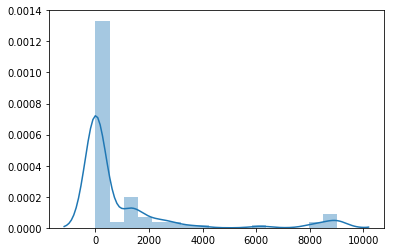

In [7]:
sns.distplot(listings_df.isna().sum())

From the above plot, based on the patterns in missing values, the cut off value can be chosen as 4000.That is, any column which has missing values greater than 4000 are eliminated.

In [8]:
missing_values_listings_df = pd.DataFrame({'columns' : listings_df.isnull().sum().index, "missing_values" : listings_df.isnull().sum()})
missing_values_listings_df = missing_values_listings_df[missing_values_listings_df['missing_values'] < 4000]

In [9]:
listings_df = listings_df[missing_values_listings_df["columns"]]

#### 5.2.2 Remove columns which are unnesary such as url and columns which have single value

In [10]:
 url_columns, unique_value_columns = remove_unnecessary_cols(listings_df)

a un-used column because same value: scrape_id [20191121092259]
a un-used column because same value: last_scraped ['2019-11-21']
a un-used column because same value: experiences_offered ['none']
a un-used column because same value: country_code ['US']
a un-used column because same value: country ['United States']
a un-used column because same value: has_availability ['t']
a un-used column because same value: calendar_last_scraped ['2019-11-21']
a un-used column because same value: is_business_travel_ready ['f']


In [11]:
listings_df = listings_df.drop(url_columns+unique_value_columns, axis = 1)

#### 5.2.3 Remove rows whose reviews per month is zero. Removing them because we won't be able to capture the clear picture of response

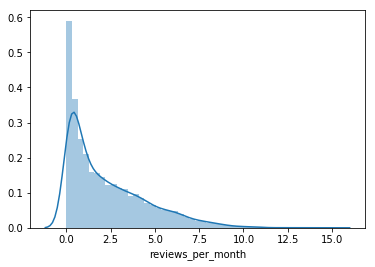

In [12]:
sns.distplot(listings_df["reviews_per_month"].dropna())

From, above plot, we can see that certain columns have zero review per month. So those, rows will be removed from analysis.

In [13]:
listings_df = listings_df[listings_df["reviews_per_month"]>0]

#### 5.2.4 Changing the format of price variable, since they are in different format and chechking their distribution. If pricr is zero, then those rows are removed from analysis

In [14]:
listings_df["price"] = dollar_cleaning(listings_df["price"])

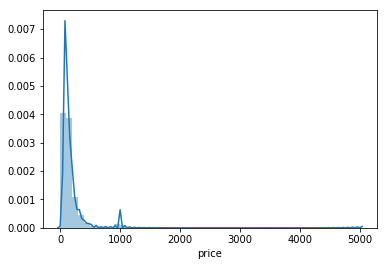

In [15]:
sns.distplot(listings_df["price"].dropna())

Removing rows whose pricing is zero, as seen above. Might be wrong data or biased

In [16]:
listings_df = listings_df[listings_df["price"] > 0]

#### 5.2.5 Mapping response time to numerical values

In [17]:
listings_df['host_response_time_str'] = response_time_mapping(listings_df, 'host_response_time')

#### 5.2.6 Cleaning data which has '%' values

In [18]:
listings_df['host_response_rate'] = percentage_cleaning(listings_df, 'host_response_rate')

#### 5.2.7 Impute numerical missing values with mean 

In [19]:
listing_df_impute = impute_numerical_values(listings_df)
listings_df = listings_df.drop(listing_df_impute.columns, axis = 1)
listings_df = pd.concat([listings_df, listing_df_impute], axis=1)

# 6. Questions

### 6.1 What are the factors on which price is dependent upon ?

In [20]:
# listings_df.columns

In [21]:
# Removing Id columns, latitude, longitude etc
listings_relevant_df = listings_df.drop(['id', 'host_id', 'latitude', 'longitude'], axis = 1)

In [22]:
listings_relevant_df_corr = listings_relevant_df.corr()

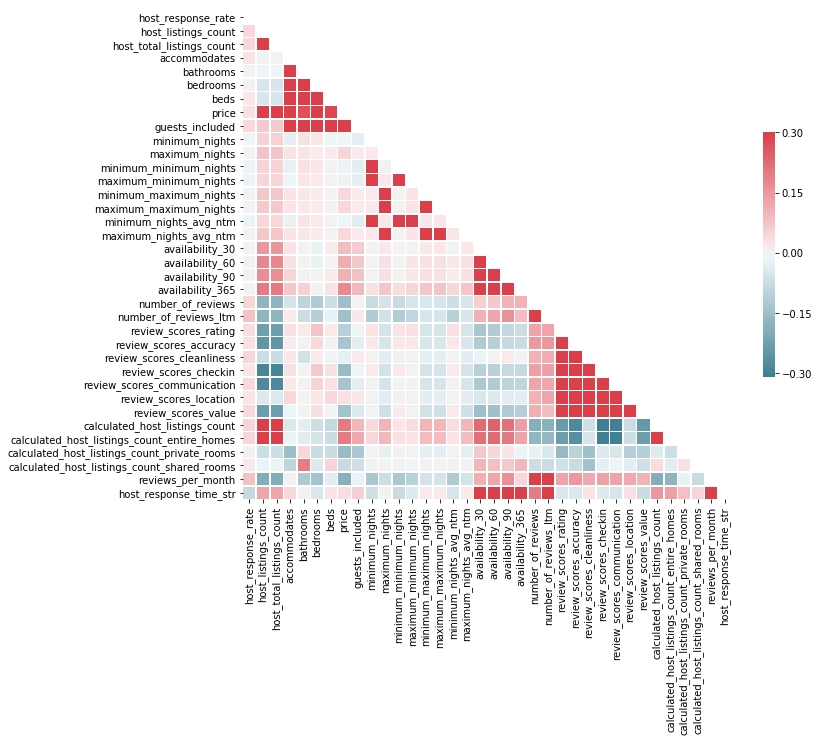

In [23]:
plot_heatmap(listings_relevant_df_corr)

From the above plt, we can say that price is directly propotional to number of bedrooms, bathrooms, accomdates and beds. But when you look at the negatively correlated values, we could say that higher the price, the less is the rating. Hence, people prefer cheaper AirBnB rooms

#### 6.2 What are top 10 neibhbourhoods with highest revenue?

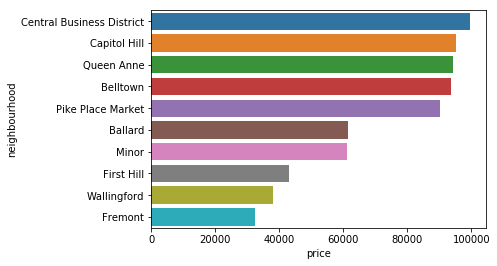

In [24]:
high_revenue_df = listings_df.groupby(['neighbourhood'])["price"].agg("sum").reset_index()
high_revenue_df = high_revenue_df.sort_values(["price"], ascending=False)
sns.barplot(high_revenue_df.price.head(10), high_revenue_df.neighbourhood.head(10))

The above bar graph displays, top 10 neighbourhoods with highest revenue. 'Central Business District' and 'Capitol Hill', has the highest revenue, which says that lot of people come for business trips can pay premium and have a short stay in that particular location.

#### 6.3 What are the top 10 neighbourhoods with least revenue?

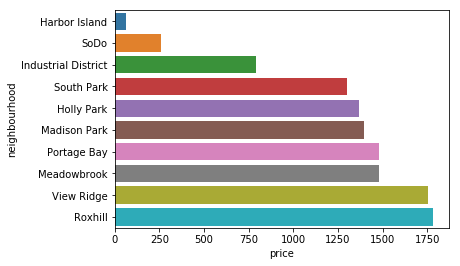

In [25]:
low_revenue_df = listings_df.groupby(['neighbourhood'])["price"].agg("sum").reset_index()
low_revenue_df = low_revenue_df.sort_values(["price"], ascending=True)
sns.barplot(low_revenue_df.price.head(10), low_revenue_df.neighbourhood.head(10))

The above bar graph displays, top 10 neighbourhoods with low revenue. 'Harbor Island' and 'SoDo', has the lowest revenue, which says that few people come for tourist destinations and they expect low cost.

#### 6.4 How is the response Rate by the host for each of the performers (Top, Medium and Low Performers)?

In [26]:
top_listings = listings_df[listings_df['review_scores_rating'] >= np.percentile(listings_df['review_scores_rating'],90)]
medium_listings = listings_df[(listings_df['review_scores_rating'] > np.percentile(listings_df['review_scores_rating'],40)) & (listings_df['review_scores_rating'] < np.percentile(listings_df['review_scores_rating'],60))]
low_listings = listings_df[listings_df['review_scores_rating'] <= np.percentile(listings_df['review_scores_rating'],10)]

hostAR_top_performer = pd.DataFrame(top_listings['host_response_rate'].reset_index(drop = True))
hostAR_top_performer['status'] = 'Top Performer'

hostAR_medium_performer = pd.DataFrame(medium_listings['host_response_rate'].reset_index(drop = True))
hostAR_medium_performer['status'] = 'Medium Performer'

hostAR_low_performer = pd.DataFrame(low_listings['host_response_rate'].reset_index(drop = True))
hostAR_low_performer['status'] = 'Low Performer'

hostAR = hostAR_low_performer.append(hostAR_top_performer).sample(frac=1)
hostAR = hostAR.append(hostAR_medium_performer).sample(frac=1)

In [27]:
pd.DataFrame(hostAR.groupby(['status'])['host_response_rate'].mean().reset_index())

,status,host_response_rate
0,Low Performer,97.914764
1,Medium Performer,98.058301
2,Top Performer,98.443609


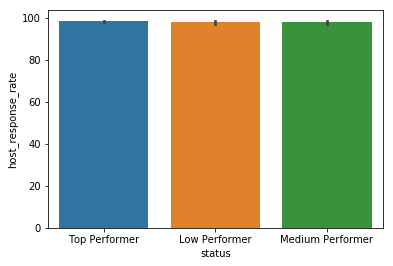

In [28]:
sns.barplot(hostAR.status, hostAR.host_response_rate)

As we can see from the above plot, top performers are those who have very high response rate. So for AirBnb, to increase their conversion, they need to increase their response rate.

#### 6.5 How is the sentiment of the customers who have taken AirBnB during given Period ?

In [29]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2318,146,2008-09-15,2451,Kevin,1000 times better than staying at a hotel.
1,2318,126302712,2017-01-10,12332845,Jessica,"Our family (two couples, a two year old and an..."
2,2318,140977084,2017-04-01,4789466,Ivan,Top of the list locations we have stayed at! T...
3,2318,147262504,2017-04-25,55817131,Mike,"SUCH an awesome place. Very clean, quiet and s..."
4,2318,161806368,2017-06-18,113604590,Pete,We flew quite a distance to be at our only dau...


In [30]:
afinn = Afinn()

In [31]:
sentiment_score = []
reviews_df = reviews_df.dropna()
reviews_df.index = np.arange(0, len(reviews_df))
sentiment_score = [afinn.score(i) for i in reviews_df.comments]
reviews_df["sentiment_score"] = sentiment_score

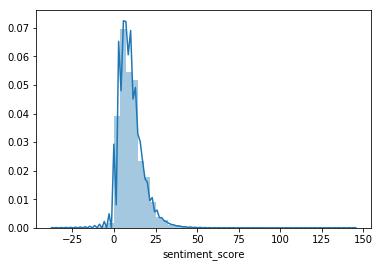

In [32]:
sns.distplot(reviews_df.sentiment_score)

In [33]:
reviews_df['sentiment'] = np.where(reviews_df['sentiment_score'] > 5, 'positive', np.where(reviews_df['sentiment_score'] < 0, 'negative', 'neutral'))

In [34]:
sentiment_counts = pd.DataFrame({"sentiment" : reviews_df.sentiment.value_counts().index, "counts" : reviews_df.sentiment.value_counts()})

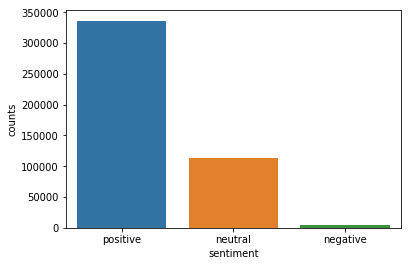

In [35]:
sns.barplot(sentiment_counts.sentiment.head(10), sentiment_counts.counts.head(10))

As you can see from the above plot, AirBnb has received majority Positive Sentiment, which suggests that they are performing pretty well and able to meet customer demands

# 7. Summary   

 As you can see from the above analysis, AirBnb has been doing pretty well in Seattle. AirBnb should continue with their goodwork and keep an eye on the competition